In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [15]:
mosaic = '/Users/vestrada/Downloads/goodss_3dhst.v4.0.F160W_orig_sci.fits'
seg_map = '/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits'
catalog = '/Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat'
instrument = 'G102' # or G141

galaxy_id = 41520

ref_cat = Table.read(catalog ,format='ascii')

galaxy_ra = float(ref_cat['ra'][ref_cat['id'] == galaxy_id])
galaxy_dec = float(ref_cat['dec'][ref_cat['id'] == galaxy_id])

In [17]:
def Source_present(fn,ra,dec):  ### finds source in flt file, returns if present and the pos in pixels
    flt=fits.open(fn)
    present = False
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 < pos[0] < xpixlim and 0 < pos[1] < ypixlim and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
            
    return present,pos

In [18]:
flt_files = glob('/Users/vestrada/Clear_data/s_flt_files/*')


goodflts = []
for i in flt_files:
    in_flt,loc = Source_present(i,galaxy_ra,galaxy_dec)
    if in_flt:
        goodflts.append(i)
        print('x={0:0.1f} y={1:0.1f}, PA={2:0.1f}, file={3} '.format(
            loc[0],loc[1],fits.open(i)[0].header['PA_V3'], os.path.basename(i)))

In [12]:
orient_1 = '/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits' 


In [20]:
flt = model.GrismFLT(grism_file = orient_1 ,
                          ref_file = mosaic, seg_file = seg_map,
                            pad=200, ref_ext=0, shrink_segimage=True, force_grism = instrument)
    
# catalog / semetation image
seg_cat = flt.blot_catalog(ref_cat,sextractor=False)

Image cutout: x=slice(5790, 11056, None), y=slice(12084, 17506, None)
/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits / blot reference /Users/vestrada/Downloads/goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(5790, 11056, None), y=slice(12084, 17506, None)
/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits / blot segmentation /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [71]:
flt.compute_full_model(ids=seg_cat['id'],)
beam = flt.object_dispersers[galaxy_id][2]['A']

In [42]:
co = model.BeamCutout(flt, beam, conf=flt.conf,min_mask=-.1)


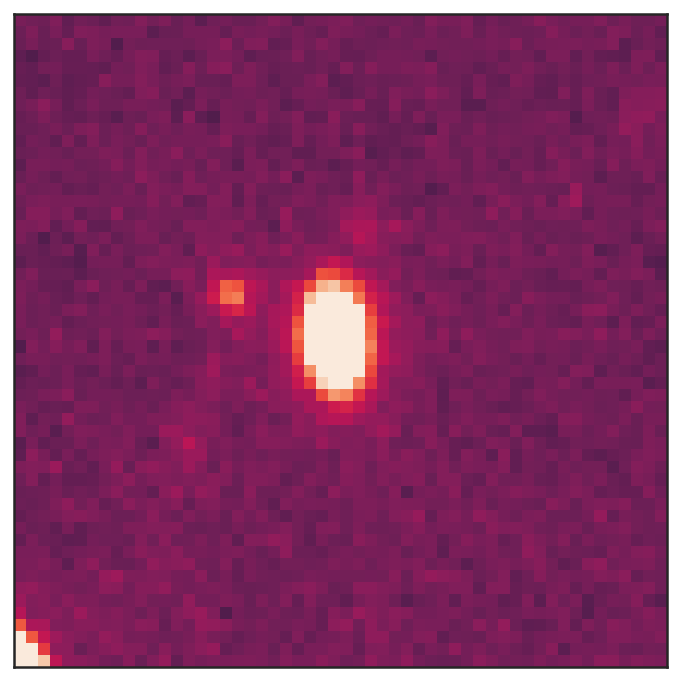

In [104]:
plt.figure(figsize=[6,6])
plt.imshow(np.arcsinh(beam.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=0.6E-20)
plt.xticks([])
plt.yticks([])
plt.savefig('../plots/41520_direct.png')

(-2.5e-21, 6e-21)

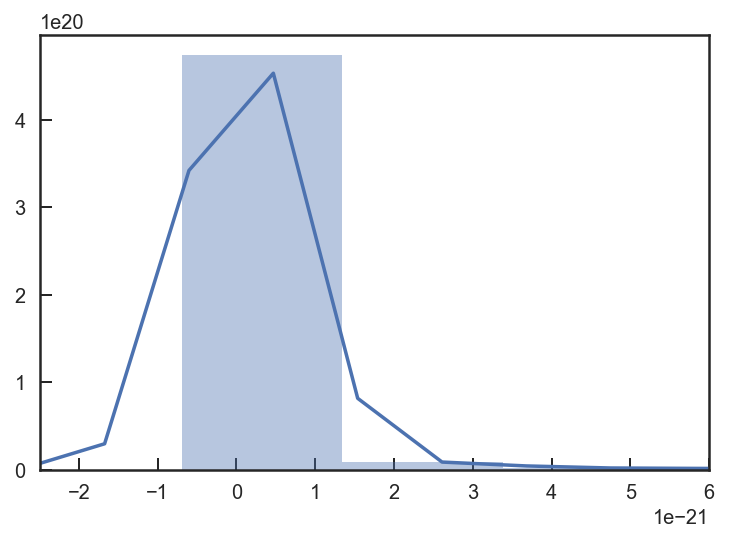

In [89]:
sea.distplot(np.arcsinh(beam.direct.flat))
plt.xlim(-.25E-20,.6E-20)

In [105]:
mosaic = '/Users/vestrada/Downloads/goodsn_3dhst.v4.0.F160W_orig_sci.fits'
seg_map = '/Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F160W_seg.fits'
catalog = '/Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.3.cat'
instrument = 'G102' # or G141

galaxy_id = 21156

ref_cat = Table.read(catalog ,format='ascii')

galaxy_ra = float(ref_cat['ra'][ref_cat['id'] == galaxy_id])
galaxy_dec = float(ref_cat['dec'][ref_cat['id'] == galaxy_id])

In [106]:
flt_files = glob('/Users/vestrada/Clear_data/n_flt_files/*')


goodflts = []
for i in flt_files:
    in_flt,loc = Source_present(i,galaxy_ra,galaxy_dec)
    if in_flt:
        goodflts.append(i)
        print('x={0:0.1f} y={1:0.1f}, PA={2:0.1f}, file={3} '.format(
            loc[0],loc[1],fits.open(i)[0].header['PA_V3'], os.path.basename(i)))

x=152.3 y=310.9, PA=345.0, file=icat21cfq_flt.fits 
x=227.3 y=314.4, PA=345.0, file=icat21coq_flt.fits 
x=158.8 y=320.9, PA=345.0, file=icat21dgq_flt.fits 
x=148.8 y=317.4, PA=345.0, file=icat21dlq_flt.fits 
x=-26.3 y=850.8, PA=195.0, file=icat25hcq_flt.fits 
x=-16.3 y=854.3, PA=195.0, file=icat25hiq_flt.fits 
x=-19.8 y=860.8, PA=195.0, file=icat25icq_flt.fits 
x=-29.9 y=857.4, PA=195.0, file=icat25iiq_flt.fits 
x=279.9 y=838.7, PA=345.0, file=icxt51jvq_flt.fits 
x=289.9 y=842.2, PA=345.0, file=icxt51jwq_flt.fits 
x=286.4 y=848.7, PA=345.0, file=icxt51jzq_flt.fits 
x=276.4 y=845.2, PA=345.0, file=icxt51k1q_flt.fits 
x=128.7 y=708.3, PA=308.9, file=icxt52i0q_flt.fits 
x=138.7 y=711.8, PA=308.9, file=icxt52i1q_flt.fits 
x=135.1 y=718.3, PA=308.9, file=icxt52i4q_flt.fits 
x=125.1 y=714.9, PA=308.9, file=icxt52i6q_flt.fits 
x=128.7 y=708.2, PA=308.9, file=icxt53i9q_flt.fits 
x=138.7 y=711.7, PA=308.9, file=icxt53iaq_flt.fits 
x=135.2 y=718.3, PA=308.9, file=icxt53idq_flt.fits 
x=125.2 y=71

In [109]:
orient_1 = '/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits' 


In [114]:
flt = model.GrismFLT(grism_file = orient_1 ,
                          ref_file = mosaic, seg_file = seg_map,
                            pad=200, ref_ext=0, shrink_segimage=True, force_grism = instrument)
    
# catalog / semetation image
seg_cat = flt.blot_catalog(ref_cat,sextractor=False)

Image cutout: x=slice(7787, 13144, None), y=slice(8991, 14205, None)
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / blot reference /Users/vestrada/Downloads/goodsn_3dhst.v4.0.F160W_orig_sci.fits[0]
Using default C-based coordinate transformation...
Image cutout: x=slice(7787, 13144, None), y=slice(8991, 14205, None)
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / blot segmentation /Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F160W_seg.fits[0]
Using default C-based coordinate transformation...
Using default C-based coordinate transformation...


In [115]:
flt.compute_full_model(ids=seg_cat['id'],)
beam = flt.object_dispersers[galaxy_id][2]['A']

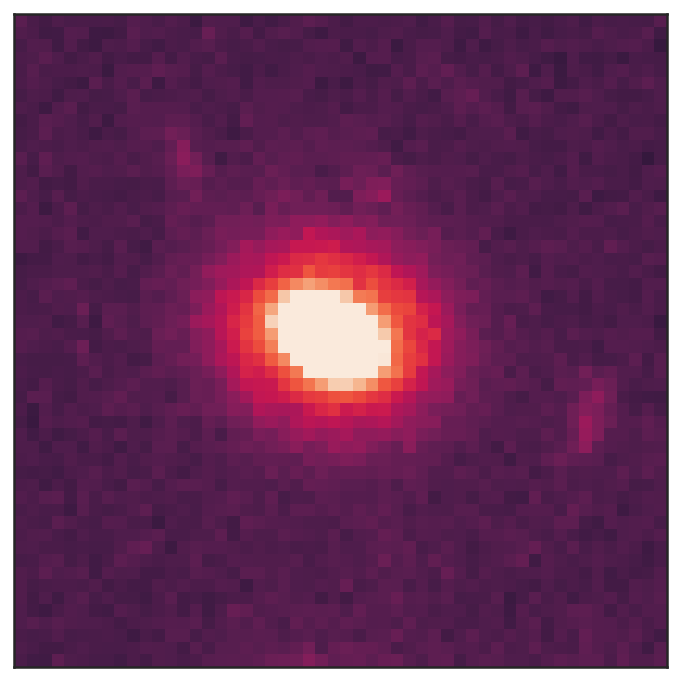

In [119]:
plt.figure(figsize=[6,6])
plt.imshow(np.arcsinh(beam.direct), interpolation='none', origin='upper', 
               vmin=-0.25E-20, vmax=1E-20)
plt.xticks([])
plt.yticks([])
plt.savefig('../plots/21156_direct.png')

(-2.5e-21, 1e-20)

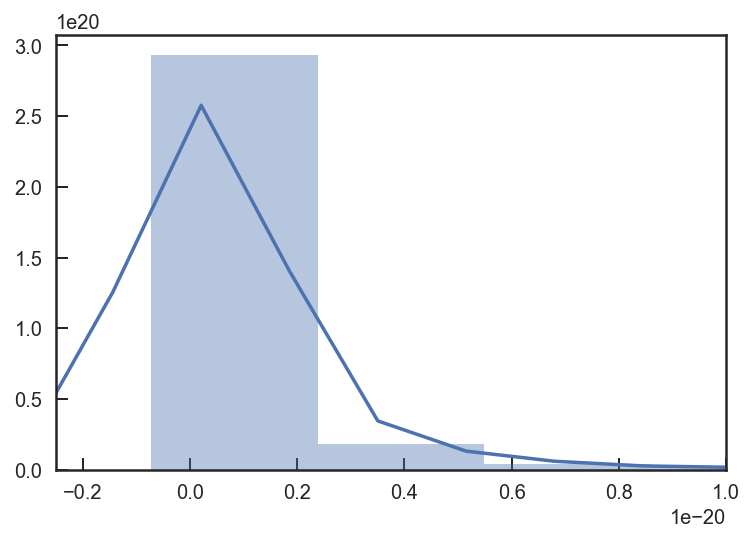

In [118]:
sea.distplot(np.arcsinh(beam.direct.flat))
plt.xlim(-.25E-20,1E-20)

In [4]:
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


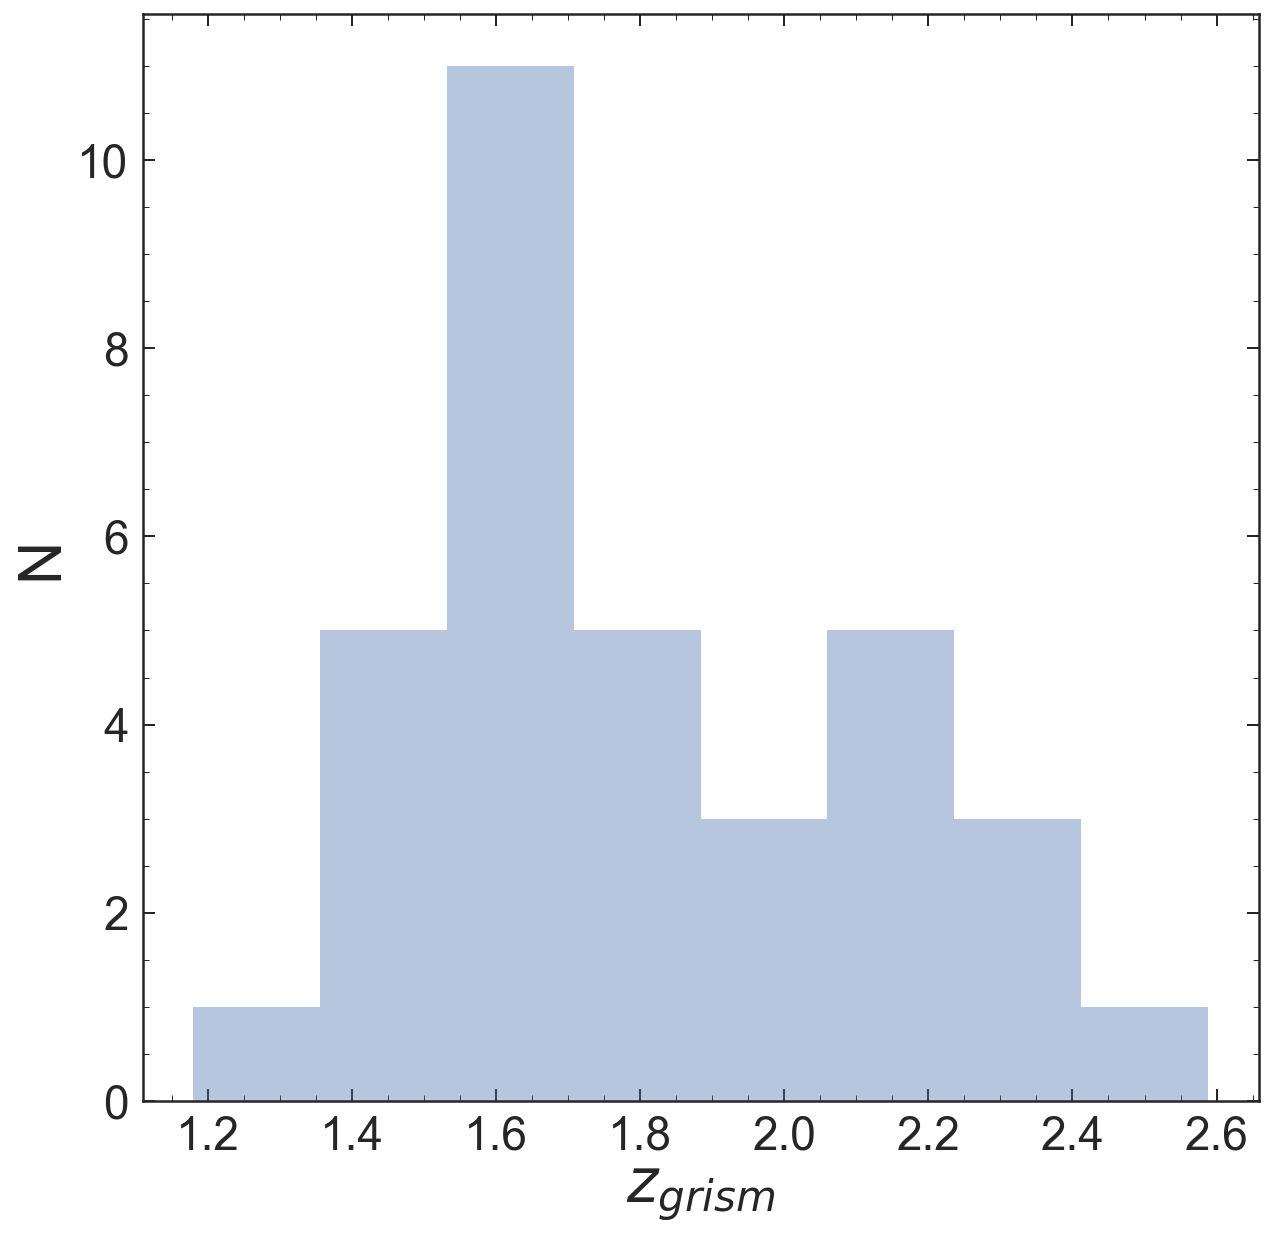

In [64]:
plt.figure(figsize=[10,10])
sea.distplot(galDB.z_grism,bins=8,kde=False)
plt.ylabel('N',size=30)
plt.xlabel('$z_{grism}$',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.savefig('../plots/sample_hist.png',bbox_inches = 'tight')

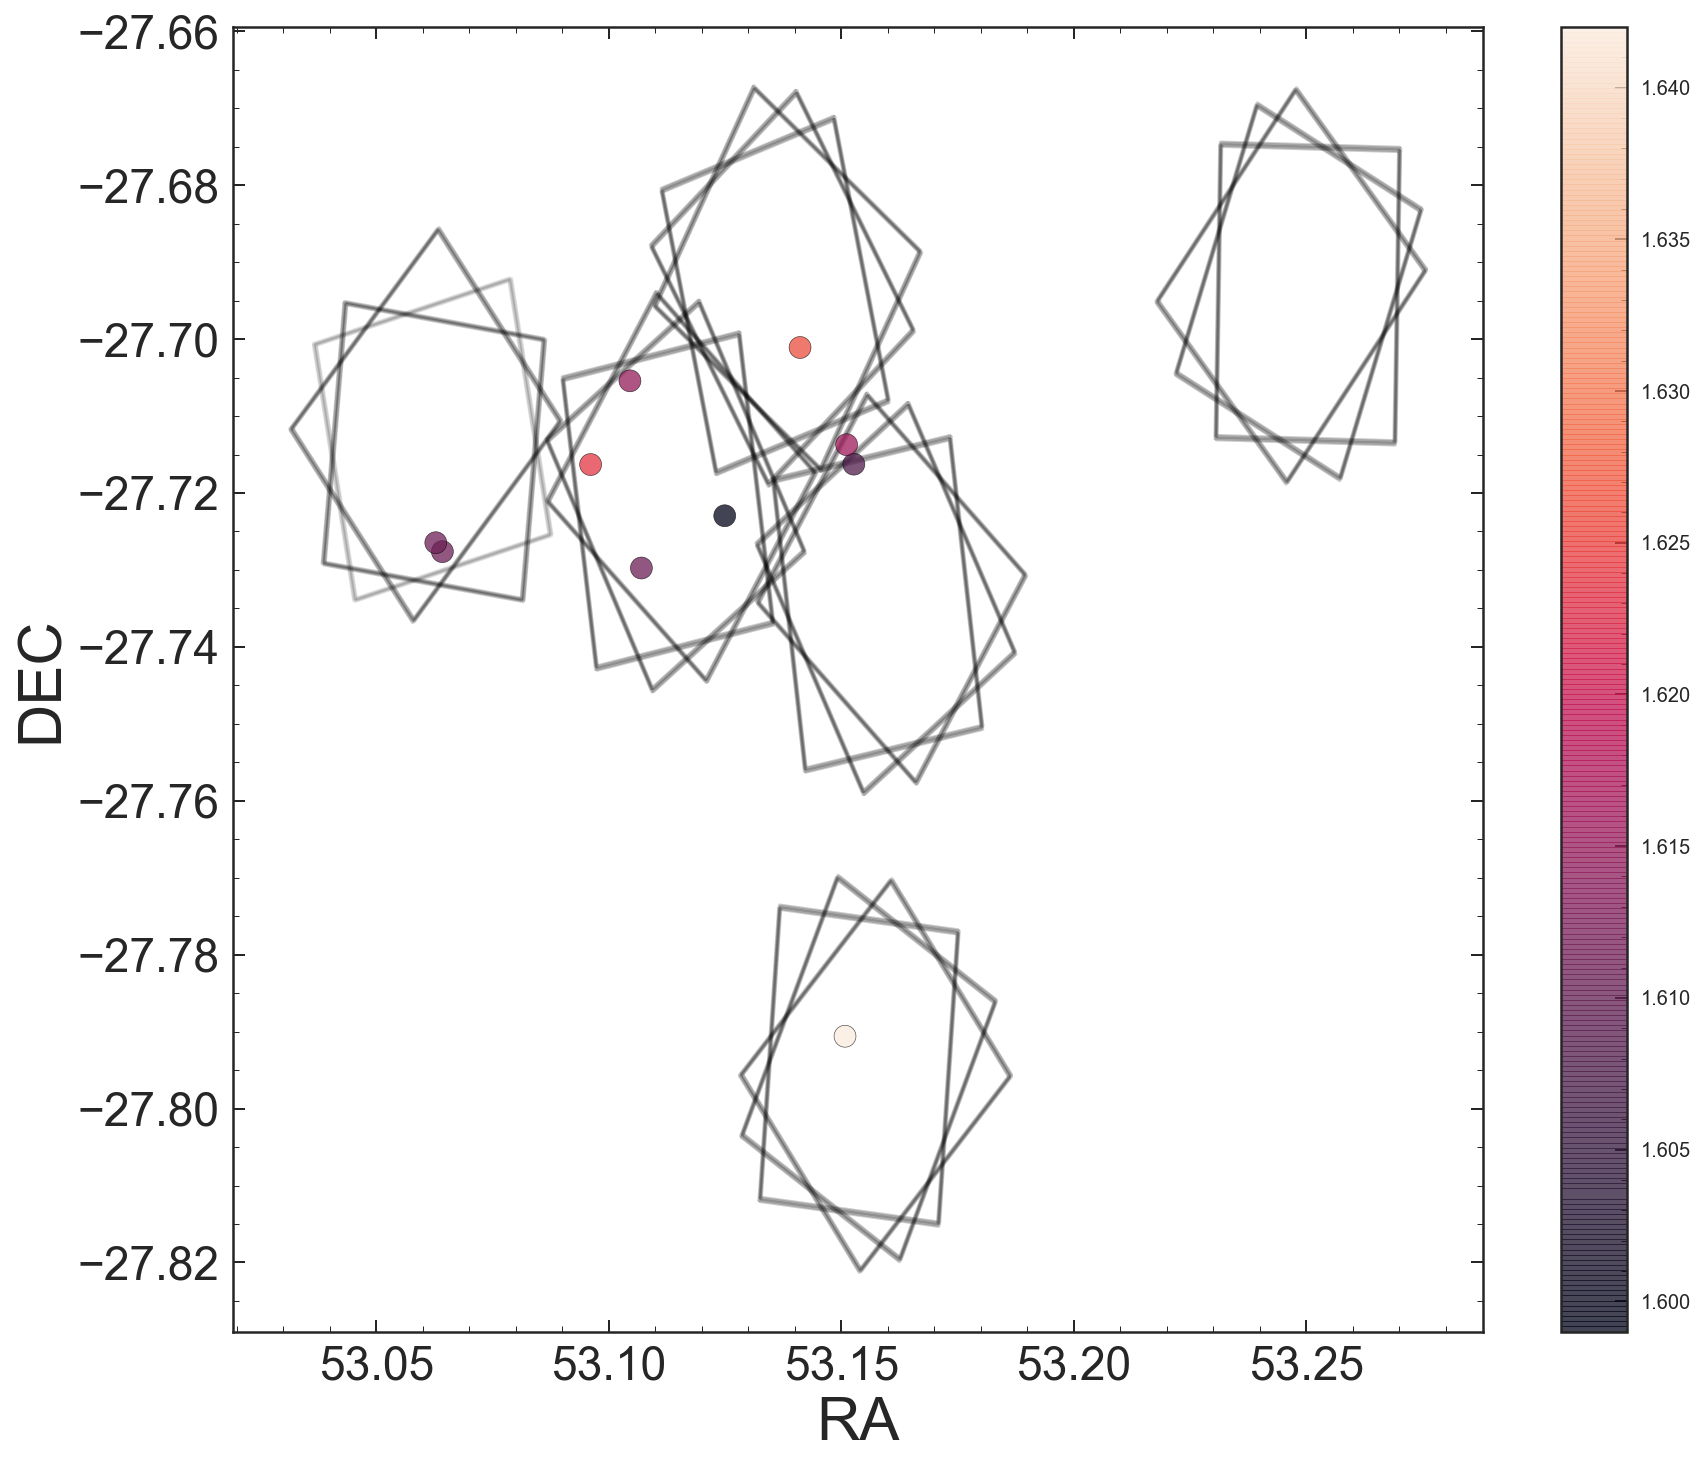

In [65]:
plt.figure(figsize=[14,12])
T = galDB.query('field == "GSD"').query('1.59 < z_grism < 1.65').z_grism

plt.scatter(galDB.query('field == "GSD"').query('1.59 < z_grism < 1.65').ra,
         galDB.query('field == "GSD"').query('1.59 < z_grism < 1.65').dec, s=120, c=T, alpha=.75,zorder=5,edgecolors='k')

for i in Sflts:
    p1,p2,p3,p4 = flt_pos(i)
    allpos = np.array([p1,p2,p3,p4,p1]).T
    plt.plot(allpos[0],allpos[1], 'k',alpha = 0.1,zorder=1)
plt.colorbar()
plt.xlabel('RA',size=30)
plt.ylabel('DEC',size=30)
plt.tick_params(axis='both', which='major', labelsize=23)
plt.savefig('../plots/sample_location.png',bbox_inches = 'tight')

# plt.figure(figsize=[6,6])
# plt.plot(galDB.query('field == "GND"').query('1.5 < z_grism < 1.7').ra,
#          galDB.query('field == "GND"').query('1.5 < z_grism < 1.7').dec,'o')

In [66]:
galDB.query('field == "GSD"').query('1.59 < z_grism < 1.65').ra

12    53.150826
16    53.107039
17    53.064240
18    53.062821
19    53.124956
22    53.152726
23    53.096114
25    53.151174
29    53.104570
30    53.141158
Name: ra, dtype: float64

In [13]:
Sflts = glob('/Users/Vince.ec/Clear_data/s_flt_files/*')

In [18]:
def flt_pos(fn):
    flt=fits.open(fn)
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    pos=w.wcs_pix2world([[0,0],[xpixlim, 0],[xpixlim, ypixlim],[0, ypixlim]],1)
            
    return pos

In [20]:
p1,p2,p3,p4 = flt_pos(Sflts[0])

allpos = np.array([p1,p2,p3,p4,p1]).T

allpos

plt.plot(allpos[0],allpos[1])

In [27]:
galDB.query('field == "GSD"').query('1.58 < z_grism < 1.68')

,field,ids,z_lres,z_grism,z_med,z_le,z_he,agn,ra,dec,...,taux,taux_l,taux_h,d,d_l,d_h,dx,dx_l,dx_h,lmass
12,GSD,26272,1.65,1.642,1.649,0.050,0.028,not,53.150826,-27.790601,...,0.223700,0.154172,0.099758,0.4,0.1,0.2,0.368368,0.142142,0.167167,10.51
16,GSD,38843,1.61,1.611,1.612,0.005,0.007,not,53.107039,-27.729749,...,0.117896,0.081620,0.108827,0.2,0.0,0.1,0.195195,0.083083,0.075075,10.35
17,GSD,39012,1.60,1.611,1.602,0.011,0.012,not,53.064240,-27.727621,...,0.287183,0.133011,0.048368,0.3,0.1,0.1,0.249249,0.084084,0.096096,11.09
18,GSD,39364,1.61,1.611,1.611,0.001,0.002,agn,53.062821,-27.726461,...,0.175333,0.108827,0.060459,0.6,0.1,0.2,0.597598,0.105105,0.148148,11.12
19,GSD,40223,1.60,1.599,1.599,0.005,0.004,not,53.124956,-27.722957,...,0.123942,0.084643,0.111850,0.5,0.1,0.2,0.490490,0.116116,0.111111,10.66
22,GSD,41520,1.61,1.608,1.611,0.003,0.004,not,53.152726,-27.716251,...,0.045345,0.033253,0.075574,0.2,0.1,0.0,0.104104,0.048048,0.052052,10.92
23,GSD,41659,1.62,1.624,1.621,0.012,0.008,not,53.096114,-27.716302,...,0.362757,0.090689,0.066505,0.5,0.1,0.1,0.473473,0.107107,0.071071,10.30
25,GSD,42113,1.62,1.616,1.617,0.002,0.002,agn,53.151174,-27.713724,...,0.078597,0.057437,0.111850,0.4,0.1,0.1,0.378378,0.091091,0.078078,11.18
29,GSD,44042,1.62,1.615,1.616,0.001,0.003,not,53.104570,-27.705421,...,0.259976,0.075574,0.066505,0.3,0.1,0.1,0.228228,0.076076,0.081081,11.02
30,GSD,44824,1.63,1.626,1.628,0.004,0.004,agn,53.141158,-27.701090,...,0.305320,0.045345,0.048368,0.4,0.1,0.1,0.324324,0.063063,0.125125,10.97


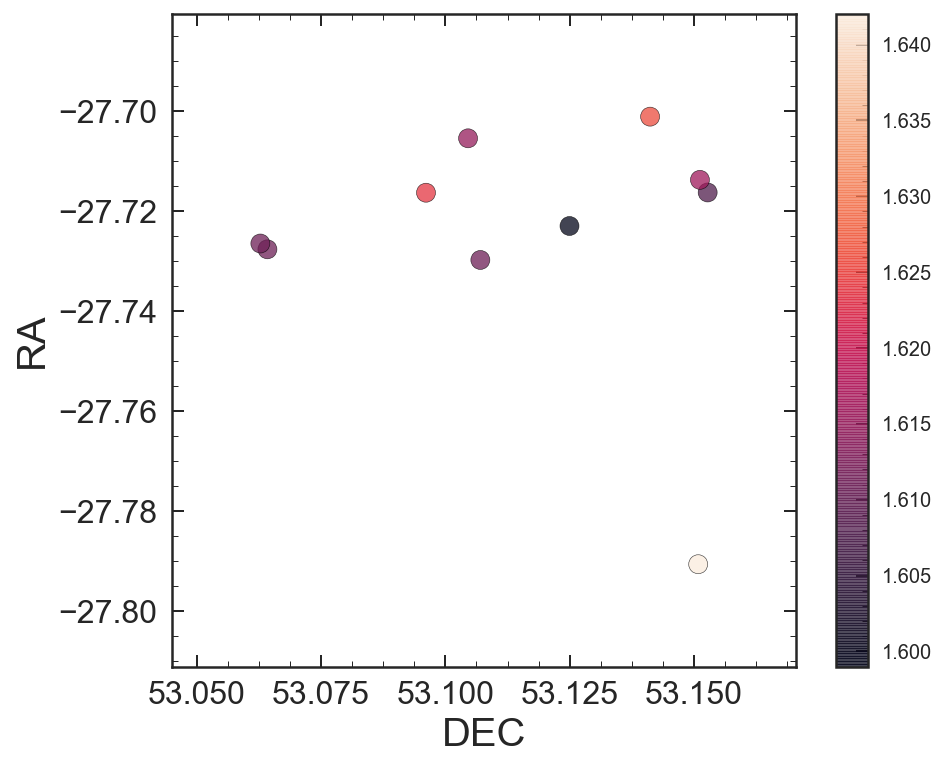

In [50]:
plt.figure(figsize=[7,6])
T = galDB.query('field == "GSD"').query('1.59 < z_grism < 1.65').z_grism

plt.scatter(galDB.query('field == "GSD"').query('1.59 < z_grism < 1.65').ra,
         galDB.query('field == "GSD"').query('1.59 < z_grism < 1.65').dec, s=90, c=T, alpha=.75,zorder=5,edgecolors='k')

ax = plt.colorbar()
# ax.set_yticklabels(ax.get_yticklabels(), fontsize=3)
plt.ylabel('RA',size=20)
plt.xlabel('DEC',size=20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [9]:
__author__ = 'vestrada'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy.interpolate import interp1d, interp2d
from glob import glob
import os
from spec_exam import Gen_spec
from grizli import multifit
from grizli import model
from astropy.cosmology import Planck13 as cosmo
import fsps
from C_full_fit import Scale_model_mult, Stitch_spec
from time import time
from sim_engine import *
from matplotlib import gridspec
hpath = os.environ['HOME'] + '/'
from spec_exam import Gen_ALMA_spec
import sys
import fsps
import dynesty
from scipy.interpolate import interp1d
from scipy import stats
from spec_tools import Oldest_galaxy
from astropy.cosmology import Planck13 as cosmo
from multiprocessing import Pool
from prospect.models.transforms import logsfr_ratios_to_masses
from spec_stats import Get_posterior

hpath = os.environ['HOME'] + '/'

if hpath == '/home/vestrada78840/':
    data_path = '/fdata/scratch/vestrada78840/data/'
    model_path ='/fdata/scratch/vestrada78840/fsps_spec/'
    chi_path = '/fdata/scratch/vestrada78840/chidat/'
    spec_path = '/fdata/scratch/vestrada78840/stack_specs/'
    beam_path = '/fdata/scratch/vestrada78840/beams/'
    template_path = '/fdata/scratch/vestrada78840/data/'
    out_path = '/fdata/scratch/vestrada78840/chidat/'
    pos_path = '/home/vestrada78840/posteriors/'
    phot_path = '/fdata/scratch/vestrada78840/phot/'

else:
    data_path = '../data/'
    model_path = hpath + 'fsps_models_for_fit/fsps_spec/'
    chi_path = '../chidat/'
    spec_path = '../spec_files/'
    beam_path = '../beams/'
    template_path = '../templates/'
    out_path = '../data/out_dict/'
    pos_path = '../data/posteriors/'
    phot_path = '../phot/'

##############################
###set useful distributions###
##############################

def Gauss_dist(x, mu, sigma):
    G = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    C = np.trapz(G, x)
    G /= C
    return G

rZ = np.arange(0.0019, 0.0302,0.0001)
r1 = np.arange(0.4999,1.5002,0.0001)
r2 = np.arange(-0.5001,0.5002,0.0001)

gZ= Gauss_dist(rZ,0.019,0.005)
g1 = Gauss_dist(r1,1,0.25)
g2 = Gauss_dist(r2,0,0.25)

iCZ = interp1d(np.cumsum(gZ) / np.cumsum(gZ).max(), rZ,fill_value=1, bounds_error=False)
iC1 = interp1d(np.cumsum(g1) / np.cumsum(g1).max(), r1,fill_value=1, bounds_error=False)
iC2 = interp1d(np.cumsum(g2) / np.cumsum(g2).max(), r2,fill_value=0, bounds_error=False)


#################################
###functiongs needed for prior###
#################################

def convert_sfh(agebins, mformed, epsilon=1e-4, maxage=None):
    #### create time vector
    agebins_yrs = 10**agebins.T
    dt = agebins_yrs[1, :] - agebins_yrs[0, :]
    bin_edges = np.unique(agebins_yrs)
    if maxage is None:
        maxage = agebins_yrs.max()  # can replace maxage with something else, e.g. tuniv
    t = np.concatenate((bin_edges * (1.-epsilon), bin_edges * (1+epsilon)))
    t.sort()
    t = t[1:-1] # remove older than oldest bin, younger than youngest bin
    fsps_time = maxage - t

    #### calculate SFR at each t
    sfr = mformed / dt
    sfrout = np.zeros_like(t)
    sfrout[::2] = sfr
    sfrout[1::2] = sfr  # * (1+epsilon)

    return (fsps_time / 1e9)[::-1], sfrout[::-1], maxage / 1e9

def get_lwa(params, agebins):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = params

    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(agebins, [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10])

    sp.set_tabular_sfh(time,sfr)    
    
    sp.params['compute_light_ages'] = True
    lwa = sp.get_mags(tage = a, bands=['sdss_g'])
    sp.params['compute_light_ages'] = False
    
    return lwa
    
####### may change to be agelim
def get_agebins(maxage):
    lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]
    
    nbins = len(lages) - 1

    tbinmax = (maxage * 0.85) * 1e9
    lim1, lim2 = 7.4772, 8.0
    agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(maxage*1e9)]
    return np.array([agelims[:-1], agelims[1:]]).T



#############
####prior####
#############

def galfit_prior(u):
#     m = (0.03*u[0] + 0.001) / 0.019
    m = iCZ(u[0]) / 0.019
    
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(a)) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.005)
    
    d = u[13]
    
    bp1 = iC2(u[14])
    
    rp1 = iC2(u[15])
    
    lwa = get_lwa([m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], get_agebins(a))
        
    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, lwa]

def zfit_prior(u):
    m = iCZ(u[0]) / 0.019
    
    a = (2)* u[1] + 1
    
    z = 2.5 * u[2]
        
    return [m, a, z]


##########################
#functions for likelihood#
##########################

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_scale(spec, Pmfl):
    return Scale_model(spec.Pflx, spec.Perr, Pmfl)

def Gather_grism_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.Bfl)
        errs.append(spec.Ber)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.Rfl)
        errs.append(spec.Rer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def Full_forward_model(spec, wave, flux, specz, wvs, flxs, errs, beams, trans):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl

def Full_calibrate(Gmfl, p1, wvs):
    for i in range(len(wvs)):
        Gmfl[i] = Gmfl[i] * ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
    return Gmfl

def Calibrate_grism(spec, Gmfl, p1, wvs, flxs, errs):
    linecal = []
    for i in range(len(wvs)):
        lines = ((p1[i] * wvs[i]) / (wvs[i][-1] - wvs[i][0]) + 5)
        scale = Scale_model(flxs[i]  / lines, errs[i] / lines, Gmfl[i])    
        linecal.append(scale * lines)
        
    return linecal


def Full_fit(spec, Gmfl, Pmfl, wvs, flxs, errs):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Gchi, Pchi

#####################
#####Likelihoods#####
#####################

def galfit_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d, bp1, rp1, lwa = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
       
    Gmfl = Full_calibrate(Gmfl, [bp1, rp1])
        
    PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, Gmfl, PC*Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

def zfit_L(X):
    m, a, z = X

    sp.params['logzsol'] = np.log10(m)
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z, wvs, flxs, errs, beams, trans)
              
    PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, Gmfl, PC*Pmfl, wvs, flxs, errs)
                  
    return -0.5 * (Gchi + Pchi)

#######################
###Fitting functions###
#######################
    
    
    

In [10]:
field = 'GND'
galaxy=21156
verbose=True
poolsize = 8

#########define fsps#########
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1),sfh = 0)

###########gen spec##########
Gs = Gen_spec(field, galaxy, 1, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = 0.02, irac_err = 0.04, decontam = True) 

####generate grism items#####
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

#######set up dynesty########
sampler = dynesty.NestedSampler(zfit_L, zfit_prior, ndim = 3, sample = 'rwalk', bound = 'multi',
                                    pool=Pool(processes= poolsize), queue_size = poolsize)

sampler.run_nested(print_progress = verbose)

dres = sampler.results

np.save(out_path + '{0}_{1}_zfit'.format(field, galaxy), dres) 

##save out P(z) and bestfit##

t,pt = Get_posterior(dres,2)
np.save(pos_path + '{0}_{1}_zfit_Pz'.format(field, galaxy),[t,pt])

bfm, bfa, bfz = dres.samples[-1]

np.save(pos_path + '{0}_{1}_zfit_bfit'.format(field, galaxy), [bfm, bfa,bfz, dres.logl[-1]])


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
iter: 2006 | bound: 18 | nc: 25 | ncall: 24460 | eff(%):  8.201 | loglstar:   -inf < -456.700 <    inf | logz: -465.604 +/-  0.124 | dlogz: 212.680 >  0.509            

Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
Exception while calling loglikelihood function:
  params: [1.31487625 2.06484305 1.28562417]
  params: [1.24339791 2.5985237  1.23741125]
  params: [1.14998058 2.5557369  1.20549467]
  params: [1.28672669 1.71890821 1.21054843]
  params: [1.39507709 1.90999304 1.2879596 ]
  params: [1.25010206 1.32246039 1.21617326]
  args: {}
  args: {}
  args: {}
  params: [0.95609425 1.29704205 1.20812288]
  args: {}
  params: [0.77973946 2.94586402 1.32127791]
  args: {}
  args: {}
  kwargs: {}
  kwargs: {}
  args: {}
  kwargs: {}
  kwargs: {}
  args: {}
  kwargs: {}
  exception:
  kwargs: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

  exception:
  kwargs: {}
  exception:
  exception:


Traceback (most recent call last):


  exception:
  exception:


Traceback (most recent call last):


  exception:


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "<ipython-input-9-d04fb9c96a4a>", line 280, in zfit_L
    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z, wvs, flxs, errs, beams, trans)
  File "/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, *

In [2]:
def Highest_density_region(Px, x, region = 0.68):
    mode = x[Px == max(Px)][0]

    vals = np.zeros_like(x)

    for i in range(len(x)):
        top_reg = np.clip(Px,Px[i],Px.max())
        top_reg[top_reg == top_reg.min()] = 0

        vals[i] = np.trapz(top_reg,x)
    try:
        lowlim = interp1d(vals[x <= mode], x[x <= mode])(0.68)
    except:
        lowlim = x.min()
    
    try:
        hilim = interp1d(vals[x >= mode], x[x >= mode])(0.68)
    except:
        hilim = x.max()
            
    return mode, mode - lowlim, hilim - mode

def Highest_density_region2(Px, x, region = 0.68):
    ####### Create fine resolution ages and metallicities
    mode = x[Px == max(Px)][0]

    ####### Create array from highest value of P2 to 0
    pbin = np.linspace(0, mode, 1000)
    pbin = pbin[::-1]

    ####### 2d integrate to find the 1 and 2 sigma values
    prob_int = np.zeros(len(pbin))

    for i in range(len(pbin)):
        p = np.array(P2)
        p[p <= pbin[i]] = 0
        prob_int[i] = np.trapz(np.trapz(p, m2, axis=1), age)

    ######## Identify 1 and 2 sigma values

    return pbin[np.argmin(onesig)], pbin[np.argmin(twosig)]

In [66]:
y,py = np.load('../data/posteriors/GND_12793_tabfit_Pm.npy')

In [83]:
def Highest_density_region(Px, x, region = 0.683):
    mode = x[Px == max(Px)][0]

    pbin = np.linspace(0, max(Px), 1000)
    pbin = pbin[::-1]

    prob_int = np.zeros(len(pbin))

    for i in range(len(pbin)):
        p = np.array(Px)
        p[p <= pbin[i]] = 0
        prob_int[i] = np.trapz(p, x)
        if prob_int[i] > region:
            break

    HCI = []
    flip = False
    for i in range(len(x)):
        if flip == False:
            if p[i] != 0:
                HCI.append(x[i])
                flip = True
        else:
            if p[i] == 0:
                HCI.append(x[i-1])
                flip = False
            if x[i] == x[-1]:
                HCI.append(x[i])                
    return mode, HCI

In [84]:
ymd, hci = Highest_density_region(py,y, region=0.683)
print(hci)

[0.6338131478058413, 0.7200674611962807, 1.1944661848436977, 1.577536811960061]


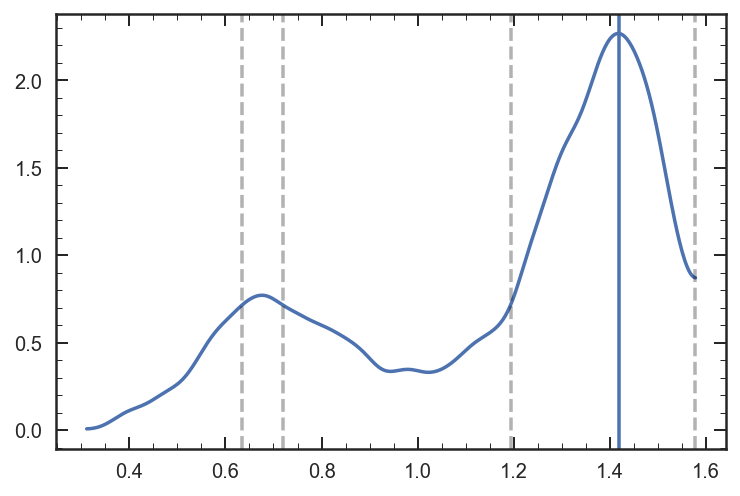

In [85]:
plt.plot(y,py)
plt.axvline(ymd)
for lim in hci:
    plt.axvline(lim, linestyle = '--', color = 'k', alpha = 0.3)

In [51]:

HCI = []
flip = False
for i in range(len(x)):
    if flip == False:
        if p[i] != 0:
            HCI.append(x[i])
            flip = True
    else:
        if p[i] == 0:
            HCI.append(x[i-1])
            flip = False

0.0014316492435928832
0.023858460629313325


In [35]:
np.trapz(py[y>0.95],y[y>0.95])

0.10948234938546768

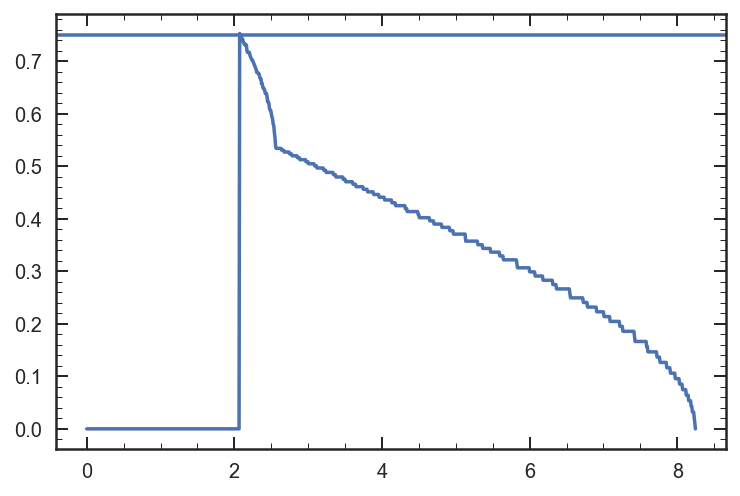

In [44]:
plt.plot(pbin, prob_int)
plt.axhline(0.75)

In [4]:
Highest_density_region(py,y)

(2.3998828715046194, 0.17896226814479954, 0.2655728801370829)

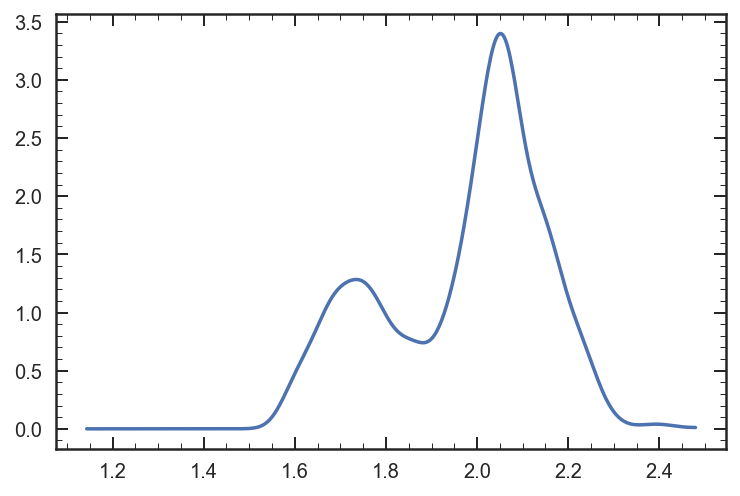

In [41]:
plt.plot(y,py)

In [32]:
def Stack(regrid_wv, wvs, fls, ers):
    """
    Stacks input spectra using a weighted mean
    
    Parameters
    ----------
    regrid_wv : wavelength array used for interpolation, idealy one of the 
        input wavelength arrays should be used here.
    
    wvs : array of the input wavelength arrays in the form of [wv1, wv2]
        where wv1 and wv2 are associated with spectrum 1 and 2 respectively
    
    fls : array of the input flux arrays in the form of [fl1, fl2]
        where fl1 and fl2 are associated with spectrum 1 and 2 respectively
    
    ers : array of the input errer arrays in the form of [er1, er2]
        where er1 and er2 are associated with spectrum 1 and 2 respectively

    Returns
    -------
    stack : output weighted mean stack 
    
    err : output stack error 
    """
    ########### generate flux and error grids by interpolating ###########
    flxgrid = np.zeros([len(fls), len(regrid_wv)])
    errgrid = np.zeros([len(ers), len(regrid_wv)])
    
    for i in range(len(wvs)):
        iflux = interp1d(wvs[i], fls[i], bounds_error=False, fill_value = 0)
        ierror = interp1d(wvs[i], ers[i], bounds_error=False, fill_value = 0)
        
        flxgrid[i] = iflux(regrid_wv)
        errgrid[i] = ierror(regrid_wv)
    
    flxgrid = flxgrid.T
    errgrid = errgrid.T
    
    ########### generate weight grid ###########
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
  
    ########### stack spectra ###########
    stack,err = np.zeros([2, len(regrid_wv)])
    for i in range(len(regrid_wv)):
        stack[i] = np.sum(flxgrid[i] * weigrid[i]) / (np.sum(weigrid[i]))
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    
    return stack, err

In [5]:
ls /Volumes/Vince_CLEAR/RELEASE_v2.1.0/*S*/*41520*

/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS2/GS2_41520.1D.fits
/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS3/GS3_41520.1D.fits


In [7]:
from astropy.io import fits

spec1 = fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS2/GS2_41520.1D.fits')
spec2 = fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS3/GS3_41520.1D.fits')

In [15]:
wv1 = spec1['G141'].data['wave']
fl1 = spec1['G141'].data['flux'] / spec1['G141'].data['flat']
er1 = spec1['G141'].data['err'] / spec1['G141'].data['flat']

wv2 = spec2['G141'].data['wave']
fl2 = spec2['G141'].data['flux'] / spec2['G141'].data['flat']
er2 = spec2['G141'].data['err'] / spec2['G141'].data['flat']


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


<ErrorbarContainer object of 3 artists>

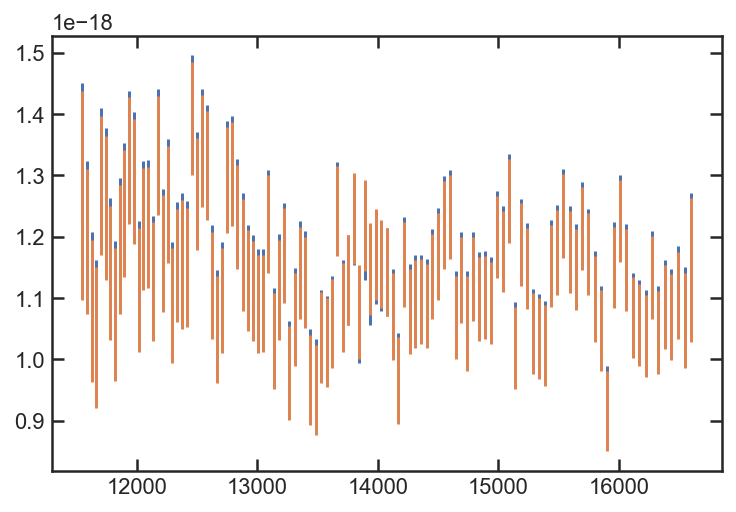

In [17]:
plt.errorbar(wv1,fl1,er1, linestyle = 'none')
plt.errorbar(wv2,fl2,er2, linestyle = 'none')

In [34]:
stack, err = Stack(wv1, [wv1,wv2], [fl1, fl2], [er1, er2])

<ErrorbarContainer object of 3 artists>

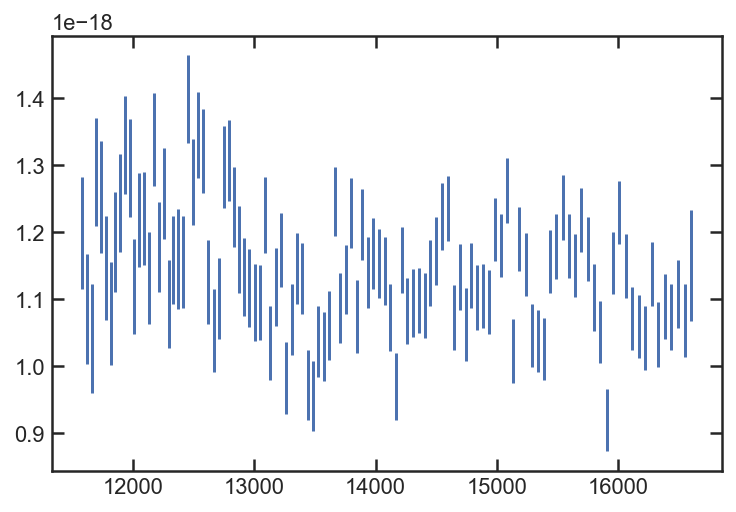

In [35]:
plt.errorbar(wv1, stack, err, linestyle = 'none')


In [44]:
from astropy.io import fits
flt_files = glob('/Users/vestrada/allfits/*fit*')

fields = ['ERSPRIME', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5', 'GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7']

for F in fields:

    flts = []
    for i in flt_files:
        dat = fits.open(i)
        if dat[0].header['TARGNAME'] == F and dat[0].header['OBSTYPE'] != 'SPECTROSCOPIC':
            flts.append(i)
    combine.combine_flt(files = flts, output='../data/field_fits/{0}.fits'.format(F))

Maximum shift (x, y) = ( 283.4,  186.3), pad=300
  1 /Users/vestrada/allfits/icxt19o9q_flt.fits    0.0    0.0     302.94
  2 /Users/vestrada/allfits/icxt19odq_flt.fits  -13.6    3.0     227.94
  3 /Users/vestrada/allfits/icxt20faq_flt.fits  283.3 -154.7     302.94
  4 /Users/vestrada/allfits/icxt20feq_flt.fits  269.5 -151.5     227.94
  5 /Users/vestrada/allfits/icxt21baq_flt.fits  283.4 -154.7     302.94
  6 /Users/vestrada/allfits/icxt21bfq_flt.fits  269.6 -151.6     227.94
  7 /Users/vestrada/allfits/icxt22ppq_flt.fits -131.7  183.1     302.94
  8 /Users/vestrada/allfits/icxt22ptq_flt.fits -145.2  186.3     227.94
  9 /Users/vestrada/allfits/icxt23pyq_flt.fits -131.7  183.2     302.94
 10 /Users/vestrada/allfits/icxt23q2q_flt.fits -145.3  186.2     227.94
Maximum shift (x, y) = ( 210.4,  184.9), pad=250
  1 /Users/vestrada/allfits/icxt07dwq_flt.fits    0.0    0.0     302.94
  2 /Users/vestrada/allfits/icxt07e1q_flt.fits    6.7   10.4     227.94
  3 /Users/vestrada/allfits/icxt08e6q_

In [42]:
flts

['/Users/vestrada/allfits/icxt46szq_flt.fits',
 '/Users/vestrada/allfits/icxt46t3q_flt.fits',
 '/Users/vestrada/allfits/icxt47xaq_flt.fits',
 '/Users/vestrada/allfits/icxt47xeq_flt.fits',
 '/Users/vestrada/allfits/icxt48mfq_flt.fits',
 '/Users/vestrada/allfits/icxt48mmq_flt.fits',
 '/Users/vestrada/allfits/icxt49hlq_flt.fits',
 '/Users/vestrada/allfits/icxt49hpq_flt.fits',
 '/Users/vestrada/allfits/icxt50huq_flt.fits',
 '/Users/vestrada/allfits/icxt50hyq_flt.fits']

In [10]:
from grizli import combine

Maximum shift (x, y) = ( 211.0,  413.5), pad=450
  1 /Users/vestrada/allfits/icxt46szq_flt.fits    0.0    0.0     227.94
  2 /Users/vestrada/allfits/icxt46t3q_flt.fits  -13.7    3.2     252.94
  3 /Users/vestrada/allfits/icxt47xaq_flt.fits  170.6 -125.3     227.94
  4 /Users/vestrada/allfits/icxt47xeq_flt.fits  177.0 -114.8     252.94
  5 /Users/vestrada/allfits/icxt48mfq_flt.fits  170.3 -125.1     227.94
  6 /Users/vestrada/allfits/icxt48mmq_flt.fits  177.0 -114.7     252.94
  7 /Users/vestrada/allfits/icxt49hlq_flt.fits -211.0  403.4     227.94
  8 /Users/vestrada/allfits/icxt49hpq_flt.fits -204.4  413.5     252.94
  9 /Users/vestrada/allfits/icxt50huq_flt.fits -211.0  403.5     227.94
 10 /Users/vestrada/allfits/icxt50hyq_flt.fits -204.3  413.5     252.94


In [14]:
dat[0].header['OBSTYPE']

'SPECTROSCOPIC'

In [1]:
from astropy.io import fits
from astropy import wcs
import numpy as np

def Segmap_add(sources,segmap_with_sources,segmap_to_adjust,file_out):
    ID=sources

    ###choose segmentation map and gather image data
    segmap = fits.open(segmap_with_sources)
    image = segmap[0].data

    ###choose which seg map to add info to
    segmap_main = fits.open(segmap_to_adjust)
    image_main = segmap_main[0].data

    ###get translation info to go from pix to wcs, or vice versa
    w=wcs.WCS(segmap[0].header)
    w_main=wcs.WCS(segmap_main[0].header)

    ###copy source into main file
    for i in range(len(ID)):
        indicies=np.argwhere(image==ID[i])
        indicies=np.transpose(indicies)
        r_min=min(indicies[0])
        c_min=min(indicies[1])
        r_max=max(indicies[0])
        c_max=max(indicies[1])
        source=image[r_min:r_max,c_min:c_max]
        source[source!=ID[i]]=0
        source[source==ID[i]]=5400000+ID[i]
        edges=w.wcs_pix2world([[c_min,r_max],[c_max,r_min]],1)
        area=w_main.wcs_world2pix(edges,1)
        rowdiff=np.absolute(r_max-r_min)
        coldiff=np.absolute(c_max-c_min)
        k=image_main[area[1][1]:area[1][1]+rowdiff,area[0][0]:area[0][0]+coldiff]
        for i in range(len(k)):
            for ii in range(len(k[0])):
                if source[i][ii]!=0:
                    k[i][ii]=source[i][ii]

    fits.writeto(file_out,image_main,header=segmap_main[0].header)

In [17]:
sources = [21750]
segmap_with_sources = '/Users/vestrada/Clear_data/segmaps/Goods_N_plus_seg.fits'
segmap_to_adjust = '/Users/vestrada/Downloads/GOODSN_segmap.fits'
file_out = '../data/test.fits'

ID = sources

###choose segmentation map and gather image data
segmap = fits.open(segmap_with_sources)
image = segmap[0].data

###choose which seg map to add info to
segmap_main = fits.open(segmap_to_adjust)
image_main = segmap_main[0].data

###get translation info to go from pix to wcs, or vice versa
w=wcs.WCS(segmap[0].header)
w_main=wcs.WCS(segmap_main[0].header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [3]:
###copy source into main file
for i in range(len(ID)):
    indicies=np.argwhere(image==ID[i])
    indicies=np.transpose(indicies)
    r_min=min(indicies[0])
    c_min=min(indicies[1])
    r_max=max(indicies[0])
    c_max=max(indicies[1])
    source=image[r_min:r_max,c_min:c_max]
    source[source!=ID[i]]=0
    source[source==ID[i]]=5400000+ID[i]
    edges=w.wcs_pix2world([[c_min,r_max],[c_max,r_min]],1)
    area=w_main.wcs_world2pix(edges,1)
    rowdiff=np.absolute(r_max-r_min)
    coldiff=np.absolute(c_max-c_min)
    k=image_main[area[1][1]:area[1][1]+rowdiff,area[0][0]:area[0][0]+coldiff]
#     for i in range(len(k)):
#         for ii in range(len(k[0])):
#             if source[i][ii]!=0:
#                 k[i][ii]=source[i][ii]

In [5]:
r_min,r_max,c_min,c_max

(10902, 10905, 11162, 11166)

In [16]:
image[r_min:r_max+1,c_min:c_max+1]

array([[      0, 5421750, 5421750, 5421750,       0],
       [5421750, 5421750, 5421750, 5421750,   21750],
       [5421750, 5421750, 5421750, 5421750,       0],
       [      0,   21750,   21750,       0,       0]], dtype=int32)

In [7]:
source=image[r_min:r_max+1,c_min:c_max+1]
source[source!=ID[i]]=0
source[source==ID[i]]=5400000+ID[i]
edges=w.wcs_pix2world([[c_min,r_max],[c_max,r_min]],1)
area=w_main.wcs_world2pix(edges,1)

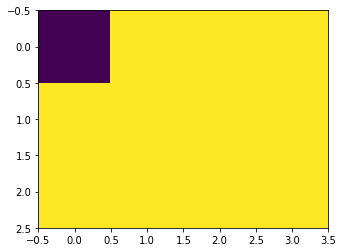

In [10]:
import matplotlib.pyplot as plt
plt.imshow(source)
plt.show()

In [11]:
source.shape

(3, 4)